# Hybrid SUV Data Roll-Up

Link to the example in the Cookbook:\
[https://mms.openmbee.org/alfresco/mmsapp/mms.html#/projects/PROJECT-ID_2[...]5/views/_18_0_6_e64033a_1490027434014_467163_56631](https://mms.openmbee.org/alfresco/mmsapp/mms.html#/projects/PROJECT-ID_2_2_17_7_33_25_AM_3ccfaf88_159fe0d7ba9__7d4e_cae_tw_jpl_nasa_gov_127_0_0_1/master/documents/_18_5_2_e64033a_1513278979739_556269_28755/views/_18_0_6_e64033a_1490027434014_467163_56631)


## Structure
![img/HSUV_structure.svg](img/HSUV_structure.svg)
## Data Roll-Up Pattern
![img/HSUV_pattern.svg](img/HSUV_pattern.svg)

In [8]:
package 'HybridSUVDynamicDataRollUp'{
    import ScalarValues::Real;
    import ScalarFunctions::sum;
    import 'DataRollUpPattern'::*;
    import Behavior::*;
    import Structure::*;
    
    value type bps specializes Real;
    
    package 'DataRollUpPattern'{
       
        block 'DataRollupAspect'{
            part subRollUp : 'DataRollupAspect'[*];
            
            value 'totalDataRate' : bps = sum(subRollUp::totalDataRate) + dataRate;    
            
            value dataRate : bps;
            
            // should the following be defined in the system? may make more sense with a more 
            // complex example; one where each component has different behavior
            
            value 'dataRateInStateOn' : bps;
            value 'dataRateInStateStandby' : bps;

            // MOVED behavior to system
            
            
            // re-use behavior with parametrization
    
        //alternative, same as classifier behavior in SysML v1
//             exhibit state 'HybridDataBehavior'
//             {
//                 // define state machine
//             }
        } //END block 'Data Roll-up Aspect'
    } // END package
        
    
    package 'Structure'{
        /*Alternative approach to behaviors: create a behavior block that specializes power roll up pattern
        and defines value properties needed for behaviors then each car component specializes that block 
        instead (example below). Currently each component exhibits the behavior separately since in general each component may
        have different behaviors.
        
        Example:
        
        block HybridBehavior specializes DataRollupAspect{
            value 'dataRateInStateOn' : bps;
            value 'dataRateInStateStandby' : bps;
            
            exhibit state behavior : 'HybridDataBehavior' (
                in dataRateInStateOn_p = dataRateInStateOn,
                in dataRateInStateStandby_p = dataRateInStateStandby,
                in dataRate_p = dataRate);
        }
        
        block BodyControl Module specializes HybridBehavior{
            redefines dataRateInStateOn = 60.0;
        }
        ...
        etc.
        */
        block 'BodyControlModule' specializes DataRollupAspect{
            exhibit state behavior : 'HybridDataBehavior' (
                in dataRateInStateOn_p = dataRateInStateOn,
                in dataRateInStateStandby_p = dataRateInStateStandby,
                in dataRate_p = dataRate);
        }
        
        block 'PowertrainControlModule' specializes DataRollupAspect{
            exhibit state behavior : 'HybridDataBehavior' (
                in dataRateInStateOn_p = dataRateInStateOn,
                in dataRateInStateStandby_p = dataRateInStateStandby,
                in dataRate_p = dataRate);
        }
        
        block 'BrakeControlModule' specializes DataRollupAspect{
            exhibit state behavior : 'HybridDataBehavior' (
                in dataRateInStateOn_p = dataRateInStateOn,
                in dataRateInStateStandby_p = dataRateInStateStandby,
                in dataRate_p = dataRate);
        }
        
        block 'BrakingSystem' specializes 'DataRollupAspect'{
            part brakeControlModule : 'BrakeControlModule' subsets subRollUp{
                redefines dataRateInStateOn = 10.0;
            }
            exhibit state behavior : 'HybridDataBehavior' (
                in dataRateInStateOn_p = dataRateInStateOn,
                in dataRateInStateStandby_p = dataRateInStateStandby,
                in dataRate_p = dataRate);
        }
        
        block 'PowerControlUnit' specializes 'DataRollupAspect'{
            part bodyControlModule : 'BodyControlModule' subsets subRollUp;
            part powertrainControlModule : 'PowertrainControlModule' subsets subRollUp{
                redefines dataRateInStateOn = 15.0;
            }
            exhibit state behavior : 'HybridDataBehavior' (
                in dataRateInStateOn_p = dataRateInStateOn,
                in dataRateInStateStandby_p = dataRateInStateStandby,
                in dataRate_p = dataRate);
        }
        
        block 'HybridSUV' specializes 'DataRollupAspect'{
            part powerControlUnit : 'PowerControlUnit' subsets subRollUp;
            part brakingSystem : 'BrakingSystem' subsets subRollUp;
            
            exhibit state behavior : 'HybridDataBehavior' (
                in dataRateInStateOn_p = dataRateInStateOn,
                in dataRateInStateStandby_p = dataRateInStateStandby,
                in dataRate_p = dataRate);
        }
 
    } // END package 'Structure'
    
    package Behavior{
        attribute def DStandbySignal;
        attribute def DTurnOnSignal;
        attribute def DTurnOffSignal;
        
        // in is default
        state def 'HybridDataBehavior' (
            dataRateInStateStandby_p: bps, 
            dataRateInStateOn_p: bps,
            dataRate_p : bps) {
            
            entry;
            then Off;
            
            state Off{
//                 assert constraint {dataRate == 0.0} // invariant as long as in this state
                entry action{
                    assert constraint {dataRate_p == 0.0}
                    // should be able dataRate := 0.0; referencing the VP above. currently it'd be a new VP
                }
            }
            
            transition off_to_standby
                first Off
                accept DStandbySignal 
                then StandBy;
            
            transition off_to_on
                first Off
                accept DTurnOnSignal 
                then On;
            
            state StandBy {
                entry action{
                    assert constraint {dataRate_p == dataRateInStateStandby_p}
                    // dataRate = dataRateInStateStandby_p; // how to reference this VP?
                }
            }
            transition standby_to_off
                first StandBy
                accept DTurnOffSignal
                then Off;
            
            transition standby_to_on
                first StandBy
                accept DTurnOnSignal
                then On;
            
            state On{
                entry action{
                    assert constraint {dataRate_p == dataRateInStateOn_p}
                    // dataRate = dataRateInStateOn; // how to reference this VP?
                }
            }
            transition on_to_standby
                first On
                accept DStandbySignal then StandBy;
            transition on_to_off
                first On
                accept DTurnOffSignal then Off;
        } // END state def 'Data Roll-up Behavior'
    } // END package Behavior

    package Configurations {
        // specify different data configurations for analysis
    } // END package
    
    package 'Analysis' {
        
        block 'TestDriver'{
            /* the idea here is that the action scenario would not be defined in the definition of the roll up 
            analysis def - instead it could be defined for different scenarios by defining the actions of the 
            scenario at the usage of the analysis case, as shown below. Then if there was a different test driver,
            the actions could be different and you could have a roll up for that case as well.
            */
            attribute DTurnOn : DTurnOnSignal;
            attribute DStandBy : DTurnOnSignal;
            attribute DTurnOff : DTurnOffSignal;
            
            part hsuv:Structure::HybridSUV;
            
            analysis 'testDriverAnalysis' : 'RollUpAnalysis' (hsuv) {
                action scenario {
                    send DTurnOn to hsuv::powerControlUnit::bodyControlModule; 
                    //assert hsuv::powerControlUnit::bodyControlModule inState(On);
                    then send DStandBy to hsuv::brakingSystem::brakeControlModule;
                    //assert hsuv::powerControlUnit::brakeControlModule inState(StandbBy);
                    then send DTurnOff to hsuv::brakingSystem::brakeControlModule;
                    //assert hsuv::brakingSystem::bodyControlModule inState(StandbBy);
                }
            } total_data;
            
            value testDriverTotalData = total_data;
            
        } // END block
        
        // Analysis case, hsuv would be parameter, the subject of the analysis
        block 'AnalysisContext'{

            part hsuv : Structure::HybridSUV;
          
            // short hand
            value total_context : bps = 'RollUpAnalysis' (hsuv);
            // analysis 'roll-up-analysis' : 'RollUpAnalysis' (hsuv = 'Analysis Context'::hsuv) 
            //    total_context = 'Analysis Context'::total_context;
        } // END block
        
        analysis def 'RollUpAnalysis' (hsuv : Structure::HybridSUV) total_data : bps {
            objective{
                /* roll up data 
                formalize:
                require requirement  total_datarate
                1) rolls up data after performing certain scenario
                2) could be changed to not define scenario yet... maybe define scenario in usage?
                    - example in test driver
                */
            }
            action scenario {
                attribute DTurnOn : DTurnOnSignal;
                attribute DStandBy : DTurnOnSignal;
                
                send DTurnOn to hsuv::powerControlUnit::bodyControlModule; 
                //assert hsuv::powerControlUnit::bodyControlModule inState(On);
                then send DStandBy to hsuv::brakingSystem::brakeControlModule;
                //assert hsuv::powerControlUnit::brakeControlModule inState(StandbBy);
                then send DStandBy to hsuv::powerControlUnit::powertrainControlModule;
                //assert hsuv::brakingSystem::bodyControlModule inState(StandbBy);
            } // END scenario
            hsuv::totalDataRate
        } 
        
    } // END package 'Analysis'
} // END package 'HybridSUV Dynamic Data Roll-Up'


Package HybridSUVDynamicDataRollUp (9469eed6-228e-4824-9ef2-b8ae9282a0b2)


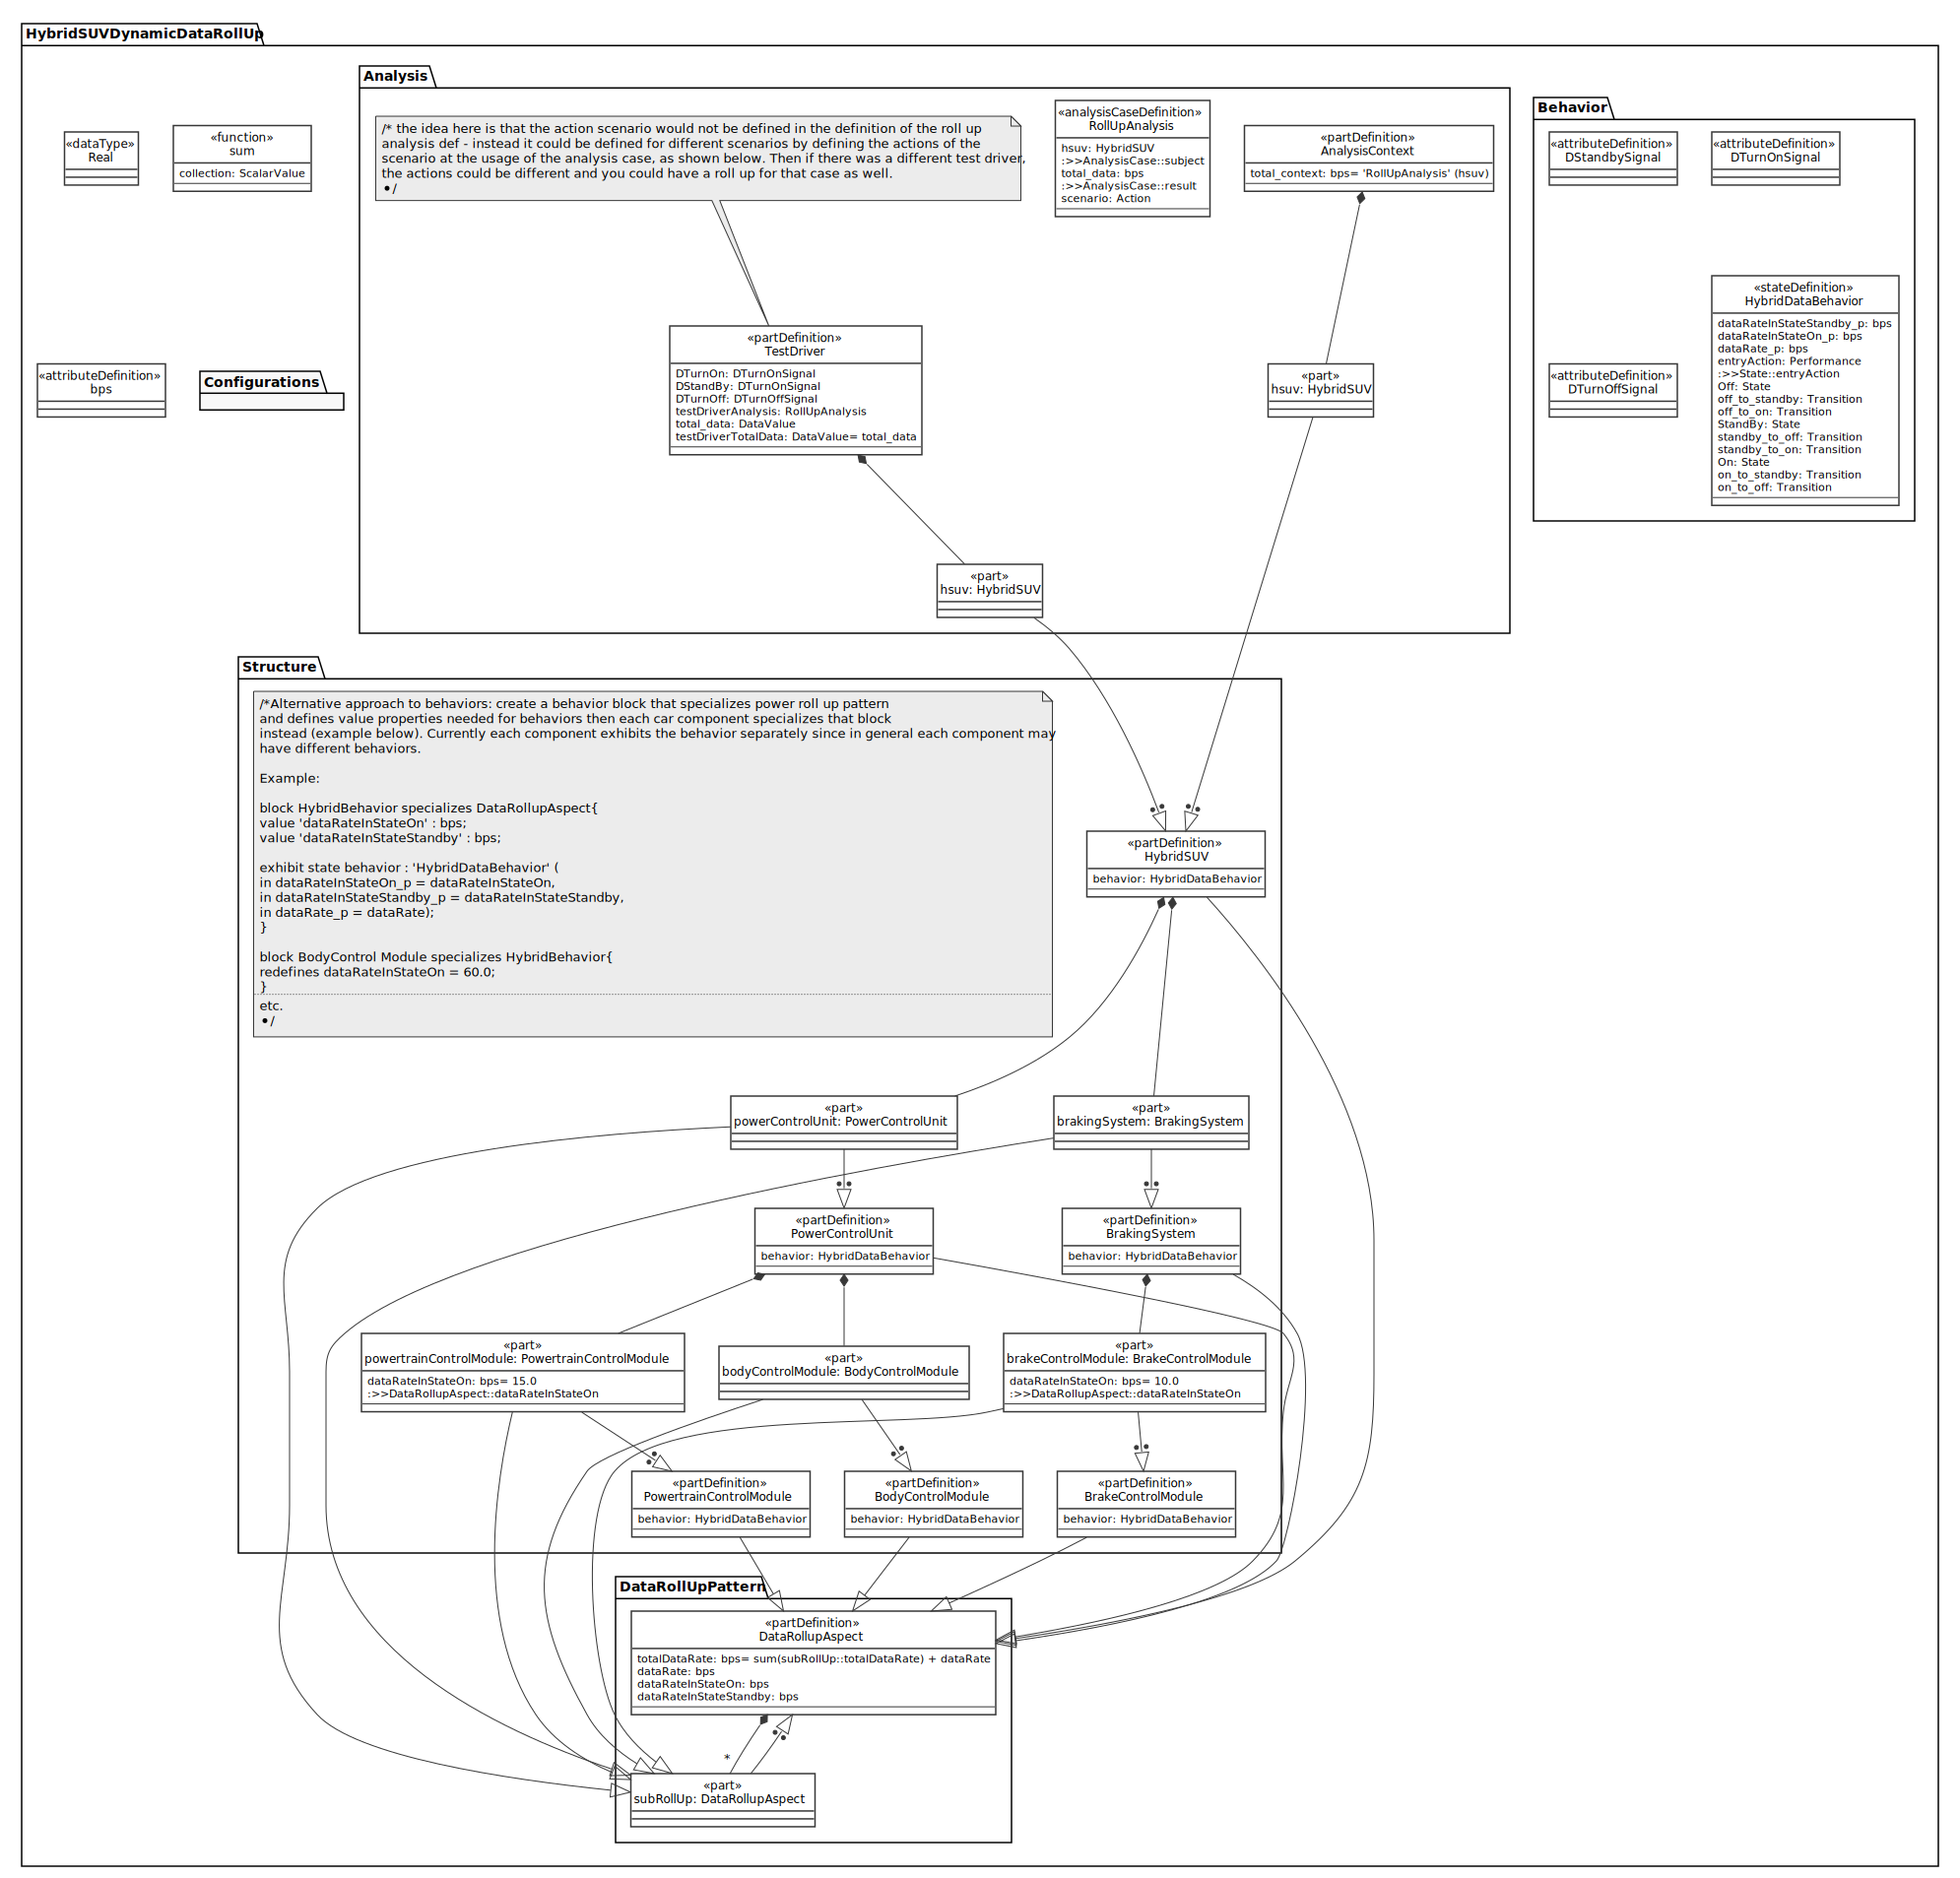

In [9]:
%viz --view=Default HybridSUVDynamicDataRollUp